## Supervised Learning: Churn Predictor

#query used
select*
from OpenQuery(YodleDB, 'with cohort as (			
		select*
		from (		
			select c.id as client_id 	
			, contractlength	
			, c.adstationmonthlybudget as budget
			, c.status
			, movetolivedate::date as first_livedate
			, deactivationdate::date as last_offdate
			, case when c.status=''LIVE'' then 0 else 1 end as churned
			, case when status=''LIVE'' then current_date- movetolivedate::date
		  		  when status=''OFF'' then deactivationdate::date - movetolivedate::date end as days_live 		
			from control.client c 	
			join control.segment seg on seg.id=c.segment_id 	
			join control.milestonedates md on md.client_id=c.id
			join 
				(select client_id from analytics.client_product_status where product=''SEM'') sem on sem.client_id=c.id 
			left join 
				(select client_id from analytics.client_product_status where product=''LIGHTHOUSE'') lh on lh.client_id=c.id  	
			left join 	
				(select client_id
				from control.testgroup tg 
				join control.testgroup_adconfiguration tgac on tgac.testgroup_id=tg.id 
				join control.adconfiguration ac on ac.id=tgac.adconfiguration_id 
				join control.adconfigurable af on af.id=ac.adconfigurable_id 
				where tg.id=142
				) tg on tg.client_id=c.id 
			where 1=1 	
			and md.movetolivedate>=current_date - interval ''3 years'' 
			and nationalaccount=''false'' 	
			and oemaccountparent_id is null 	
			and tg.client_id is null 	
			and c.status in (''LIVE'',''OFF'')
			and lh.client_id is null
			and (md.deactivationdate is null or md.deactivationdate>md.movetolivedate)
			--and c.id=175908
			) x
		order by status
		limit 10000
		),
	logins as (			
		select u.client_id				
		, count(*) as logins_30days 	
		from cohort c 		
		join authentication.users u on u.client_id=c.client_id 		
		join control.user_sessions ss on ss.user_id=u.id 		
		where 1=1		
		and u.dtype=''ClientUser''  
		and ((c.status=''LIVE'' and ss.timestamp>=current_date-interval ''30 days'' and ss.timestamp<current_date) 
		     or (c.status=''OFF'' and ss.timestamp>=c.last_offdate - interval ''30 days'' and ss.timestamp<c.last_offdate))	
		and ss.timestamp>=current_date - interval ''3 years''
		group by u.client_id  		
		),		
	leads as (			
		select l.client_id		
		, count(*) as leads_30days 	
		from cohort c 	
		join control.lead l on l.client_id=c.client_id  		
		where ((c.status=''LIVE'' and l.createddate>=current_date-interval ''30 days'' and l.createddate<current_date)
			or (c.status=''OFF'' and l.createddate>=c.last_offdate - interval ''30 days'' and l.createddate<c.last_offdate))
		and l.createddate>=current_date-interval ''3 years''
		group by l.client_id		
		),		
	spend as (			
		select s.client_id		
		, sum(amount) as spend_30days 		
		from cohort c 		
		join analytics.spend s on s.client_id=c.client_id 		
		where type=''Withdrawal'' and subtype in (''Provider Costs'',''JAG Costs'') 
		and ((c.status=''LIVE'' and s.transdate>=current_date-interval ''30 days'' and s.transdate<current_date)
			or (c.status=''OFF'' and s.transdate>=c.last_offdate - interval ''30 days'' and s.transdate<c.last_offdate)) 	
		and transdate>=current_date-interval ''3 years''		
		group by s.client_id		
		),		
	invoices as 
		(select ce.client_id 
		, sum(ili.amount) as invoices_30days 	
		from control.invoice i   
		join control.invoicetransaction it on it.invoice_id=i.id  
		join control.invoicelineitem ili on ili.invoice_id=i.id and ili.transaction_id=it.id  
		join control.chargeableentity ce on ce.id=i.chargeableentity_id   		
		join cohort c on c.client_id=ce.client_id
		where i.status in (''PAID'',''REFUNDED'') 
		and ((c.status=''LIVE'' and it.transdate>=current_date-interval ''30 days'' and it.transdate<current_date)
			or (c.status=''OFF'' and it.transdate>=c.last_offdate - interval ''30 days'' and it.transdate<c.last_offdate))
		and transdate>=current_date-interval ''3 years''
		group by ce.client_id 
		) 
	select c.client_id			
	, churned
	, days_live
	, coalesce(logins_30days,0) as logins_30days
	, coalesce(leads_30days,0) as leads_30days
	, coalesce(spend_30days,0) as spend_30days	
	, coalesce(invoices_30days,0) as invoices_30days
	from cohort c			
	--join days_live dl on dl.client_id=c.client_id
	left join logins ss on ss.client_id=c.client_id			
	left join leads l on l.client_id=c.client_id			
	left join spend s on s.client_id=c.client_id
	left join invoices i on i.client_id=c.client_id
	') x

In [1]:
import pandas as pd
#import numpy as np

#import pylab as pl
#import statsmodels.formula.api as smf
#import statsm  odels.api as sm
#from sklearn.cross_validation import KFold
#from sklearn.linear_model import LogisticRegression
#from sklearn.grid_search import GridSearchCV

#from sklearn.metrics import roc_curve, roc_auc_score
#from sklearn.cross_validation import cross_val_score

%matplotlib inline 

# Load and Prepare Dataset

In [2]:
df_raw = pd.read_csv("../assets/churn_dataset.csv")

In [3]:
df_raw.head()

,client_id,churned,days_live,logins_30days,leads_30days,spend_30days,invoices_30days
0,980,1,7,0,9,0.0,0.0
1,3471,1,153,0,1,0.0,0.0
2,4864,1,61,0,8,0.0,49.0
3,5938,1,0,0,5,0.0,0.0
4,10403,1,31,0,0,0.0,0.0


In [4]:
df_raw.shape

(10000, 7)

In [5]:
cols_to_remove = ["client_id"]

df = df_raw[[c for c in df_raw.columns if c not in cols_to_remove]]

df.columns = [x.lower() for x in df.columns]

In [6]:
df.head()

,churned,days_live,logins_30days,leads_30days,spend_30days,invoices_30days
0,1,7,0,9,0.0,0.0
1,1,153,0,1,0.0,0.0
2,1,61,0,8,0.0,49.0
3,1,0,0,5,0.0,0.0
4,1,31,0,0,0.0,0.0


In [7]:
for c in df.columns:
    print(c, len(df[df[c].isnull()]))

('churned', 0)
('days_live', 0)
('logins_30days', 0)
('leads_30days', 0)
('spend_30days', 0)
('invoices_30days', 0)


In [8]:
df.dtypes

churned              int64
days_live            int64
logins_30days        int64
leads_30days         int64
spend_30days       float64
invoices_30days    float64
dtype: object

In [9]:
df = df.dropna() 
print df.count()

churned            10000
days_live          10000
logins_30days      10000
leads_30days       10000
spend_30days       10000
invoices_30days    10000
dtype: int64


In [10]:
print df.shape
df.describe()

(10000, 6)


,churned,days_live,logins_30days,leads_30days,spend_30days,invoices_30days
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.503200,325.213400,23.338700,30.198100,272.502793,356.560297
std,0.500015,305.025301,1516.279725,72.984531,595.996663,1023.388609
min,0.000000,0.000000,0.000000,0.000000,0.000000,-11641.970000
25%,0.000000,106.000000,0.000000,4.000000,0.000000,0.000000
50%,1.000000,182.000000,0.000000,12.000000,85.490000,19.000000
75%,1.000000,499.250000,1.000000,30.000000,387.377500,500.000000
max,1.000000,1095.000000,110381.000000,3742.000000,39279.520000,48372.570000


# Exploratory Data Analysis

### Plots

In [11]:
df.churned.value_counts()

1    5032
0    4968
Name: churned, dtype: int64

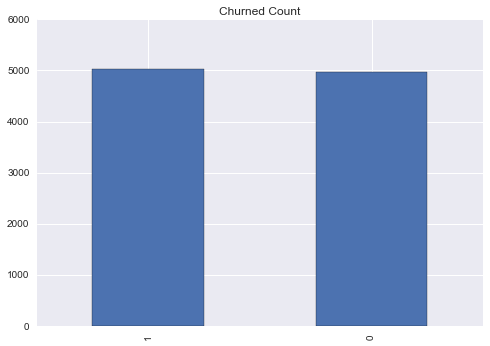

In [12]:
# LIVE and OFF counts in cohort are equal
import seaborn as sns

df.churned.value_counts().plot(kind='bar', title ="Churned Count")

(-1, 3)

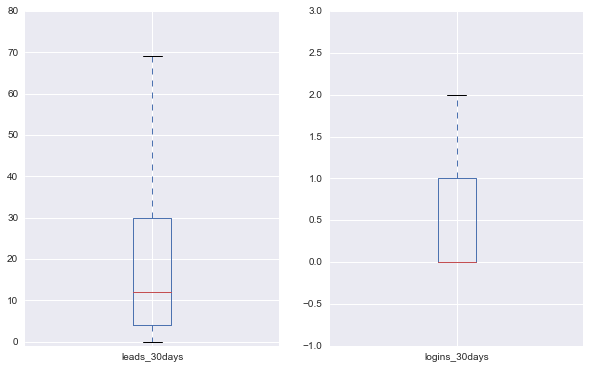

In [13]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 6))

df.leads_30days.plot(kind="box", ax=axs[0])
axs[0].set_ylim([-1, 80])

df.logins_30days.plot(kind="box", ax=axs[1])
axs[1].set_ylim([-1, 3])

,churned,days_live,logins_30days,leads_30days,spend_30days,invoices_30days
churned,1.000000,-0.418269,-0.000959,-0.188735,-0.161058,-0.300105
days_live,-0.418269,1.000000,-0.013067,0.161892,-0.026066,-0.026667
logins_30days,-0.000959,-0.013067,1.000000,0.002188,-0.006087,-0.004444
leads_30days,-0.188735,0.161892,0.002188,1.000000,0.198993,0.123642
spend_30days,-0.161058,-0.026066,-0.006087,0.198993,1.000000,0.592614
invoices_30days,-0.300105,-0.026667,-0.004444,0.123642,0.592614,1.000000


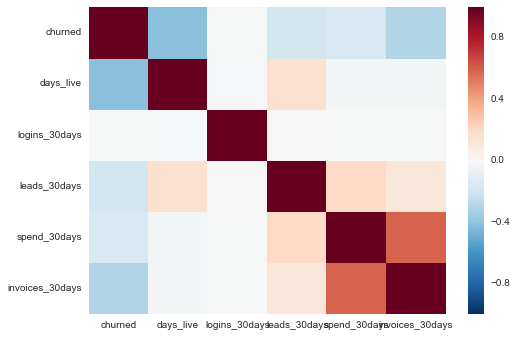

In [14]:
sns.heatmap(df.corr())
df.corr()

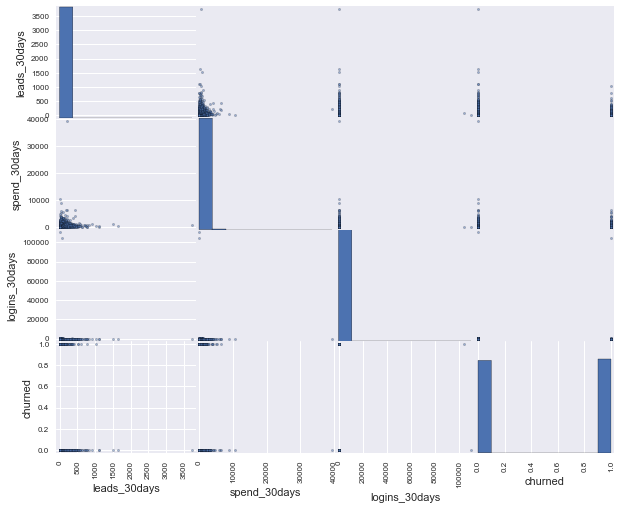

In [15]:
pd.scatter_matrix(df[['leads_30days','spend_30days','logins_30days','churned']], figsize=(10,8))
plt.show()

# Lesson 5 - Model Evaluation

## Evaluation procedure #1: Train and test on the entire dataset

Train on the entire dataset and testing on the same dataset. Then comparing the predicted response values with the true response values.

In [16]:
# define x and y
feature_cols = ['leads_30days','invoices_30days','spend_30days','logins_30days','days_live']

X = df[feature_cols]
y = df.churned

In [17]:
#import the class
from sklearn.linear_model import LogisticRegression

#instantiate the model 
logreg = LogisticRegression()

#fit the model with data
logreg.fit(X,y)

#predict the response values for observations in X
logreg.predict(X)

array([1, 1, 1, ..., 1, 1, 1])

In [18]:
#store predicted response values
y_pred = logreg.predict(X)

#check how many predictions were generated
len(y_pred)

10000

In [19]:
#compute classification accuracy for the logistic regression model; training accuracy. About 80% of the predictions were correct. 
from sklearn import metrics
print metrics.accuracy_score(y, y_pred)

0.7984


### KNN (K=5)

In [20]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X, y)
y_pred = knn.predict(X)
print(metrics.accuracy_score(y, y_pred))

0.9001


### KNN (K=1)

In [21]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X, y)
y_pred = knn.predict(X)
print(metrics.accuracy_score(y, y_pred))

0.996


Although K=1 has a better accuracy, this doesn't mean this is better. KNN looks for the nearest observation and uses it as the predicted response value for the unknown observation. Therefore, K=1 will most likely always be near 1. It has memorized the training set and we're testing on the same data. Therefore, this is not a useful procedure to choosing what model to choose. Our goal is to estimate likely performance of a model on out-of-sample data. Maximizing training accuracy rewards overly complex models that won't necessarily generalize which overfit the training data. Lower value of K will learn the noise in the data, instead of the signal.

## Evaluation procedure #2: Train/test split

In [22]:
print X.shape
print y.shape

(10000, 5)
(10000,)


In [23]:
# step 1: split into X and y training and testing sets
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 4)

In [24]:
# print the shapes of new X and y objects
print "X_train shape"
print X_train.shape
print ""
print "X_test shape"
print X_test.shape
print ""
print "Y train shape"
print y_train.shape
print ""
print "Y test shape"
print y_test.shape

X_train shape
(6000, 5)

X_test shape
(4000, 5)

Y train shape
(6000,)

Y test shape
(4000,)


In [25]:
#step 2: train the model on the training set
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [26]:
# step 3: make predictions on the training set
y_pred = logreg.predict(X_test)

# compare actual response values (y_test) with predicted response values (y_pred)
print metrics.accuracy_score(y_test, y_pred)

0.79575


### Repeat with KNN=5

In [27]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print metrics.accuracy_score(y_test, y_pred)

0.87


### Repeat with KNN=1

In [28]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print metrics.accuracy_score(y_test, y_pred)

0.8385


## Can we find a better value for K?

In [29]:
#try k=1 through k=15 and record testing accuracy
k_range = range(1,15)
scores=[]
for k in k_range: 
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores.append(metrics.accuracy_score(y_test, y_pred))

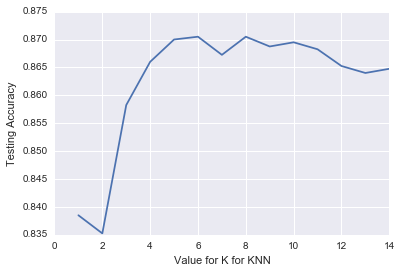

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline 

# plot relationship between K and testing accuracy
plt.plot(k_range, scores)
plt.xlabel("Value for K for KNN")
plt.ylabel("Testing Accuracy")

 - Training accuracy rises as model complexity increases
 - Testing accuracy penalizes models that are too complex or not complex enough
 - In KNN, a lower value of K means more complexity


## Making predictions on out-of-sample data

In [31]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X, y)
knn.predict([3, 100, 30, 3, 68])

/Users/csiu87/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([1])

End of lesson 5

# Lesson 7: Cross validation

In [32]:
from sklearn.cross_validation import cross_val_score

In [33]:
feature_cols = ['leads_30days','invoices_30days','spend_30days','logins_30days','days_live']

In [34]:
X = df[feature_cols]
y = df.churned

In [35]:
# 10-fold cross validation with K=5 for KNN 
knn = KNeighborsClassifier(n_neighbors=10)
scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
print scores

[ 0.87612388  0.83816184  0.757       0.787       0.782       0.734       0.76
  0.741       0.8038038   0.61661662]


In [36]:
#use average accuracy as an estimate of out-of-sample accuracy
print scores.mean()

0.769570613471


In [37]:
#search for an optimal value of K for KNN
k_range = list(range(1, 31))
k_scores = []
for k in k_range: 
    knn = KNeighborsClassifier(n_neighbors = k)
    scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
print k_scores

[0.69568487418487412, 0.71978958188958186, 0.72977979207979204, 0.74677919987919983, 0.74667699987699998, 0.75827830377830385, 0.75397780227780231, 0.75857790277790271, 0.75627810277810281, 0.76957061347061351, 0.76477220887220887, 0.77766381906381921, 0.77766381906381921, 0.78226482086482085, 0.78156482066482069, 0.78466572256572253, 0.78436562266562271, 0.78436512296512295, 0.78316562286562275, 0.7828667223667225, 0.78136722246722257, 0.78306652396652399, 0.78256702406702405, 0.78056752296752296, 0.78316702386702397, 0.78286692336692343, 0.78316632356632354, 0.78226692316692303, 0.78306752316752315, 0.7832671231671231]


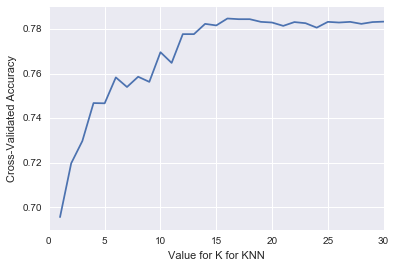

In [38]:
#plot the value of K for KNN versus the cross-validated accuracy
plt.plot(k_range, k_scores)
plt.xlabel('Value for K for KNN')
plt.ylabel('Cross-Validated Accuracy')

In [39]:
# 10-fold cross- validation with the best KNN model 
knn = KNeighborsClassifier(n_neighbors=16)
print cross_val_score(knn, X, y, cv=10, scoring='accuracy').mean()

0.784665722566


In [40]:
# 10 fold cross-validation with Logistic Regression
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
print cross_val_score(logreg, X, y, cv=10, scoring='accuracy').mean()

0.790946321546


End of lesson 7

# Lesson 8: GridSearchCV

In [41]:
from sklearn.grid_search import GridSearchCV

In [42]:
# define x and y
feature_cols = ['leads_30days','invoices_30days','spend_30days','logins_30days','days_live']

X = df[feature_cols]
y = df.churned

In [43]:
# define parameter that should be searched
k_range = range(1,31)
print k_range

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


In [44]:
#create a parameter grid; map the parameter names to the values that should be searched
param_grid = dict(n_neighbors = k_range)
print param_grid

{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]}


In [45]:
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')

In [46]:
grid.fit(X,y)

GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=16, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [47]:
#view results
grid.grid_scores_

[mean: 0.69570, std: 0.05098, params: {'n_neighbors': 1},
 mean: 0.71980, std: 0.04467, params: {'n_neighbors': 2},
 mean: 0.72980, std: 0.05782, params: {'n_neighbors': 3},
 mean: 0.74680, std: 0.05577, params: {'n_neighbors': 4},
 mean: 0.74670, std: 0.05920, params: {'n_neighbors': 5},
 mean: 0.75830, std: 0.05610, params: {'n_neighbors': 6},
 mean: 0.75400, std: 0.05949, params: {'n_neighbors': 7},
 mean: 0.75860, std: 0.05611, params: {'n_neighbors': 8},
 mean: 0.75630, std: 0.05814, params: {'n_neighbors': 9},
 mean: 0.76960, std: 0.06589, params: {'n_neighbors': 10},
 mean: 0.76480, std: 0.06445, params: {'n_neighbors': 11},
 mean: 0.77770, std: 0.07458, params: {'n_neighbors': 12},
 mean: 0.77770, std: 0.07473, params: {'n_neighbors': 13},
 mean: 0.78230, std: 0.07360, params: {'n_neighbors': 14},
 mean: 0.78160, std: 0.07435, params: {'n_neighbors': 15},
 mean: 0.78470, std: 0.07245, params: {'n_neighbors': 16},
 mean: 0.78440, std: 0.07303, params: {'n_neighbors': 17},
 mean:

In [48]:
#examine the first type
print grid.grid_scores_[0].parameters
print grid.grid_scores_[0].cv_validation_scores
print grid.grid_scores_[0].mean_validation_score

{'n_neighbors': 1}
[ 0.69030969  0.75624376  0.752       0.748       0.708       0.691       0.678
  0.638       0.71071071  0.58458458]
0.6957


In [49]:
#list of mean scores only
grid_mean_scores = [result.mean_validation_score for result in grid.grid_scores_]
print grid_mean_scores

[0.69569999999999999, 0.7198, 0.7298, 0.74680000000000002, 0.74670000000000003, 0.75829999999999997, 0.754, 0.75860000000000005, 0.75629999999999997, 0.76959999999999995, 0.76480000000000004, 0.77769999999999995, 0.77769999999999995, 0.7823, 0.78159999999999996, 0.78469999999999995, 0.78439999999999999, 0.78439999999999999, 0.78320000000000001, 0.78290000000000004, 0.78139999999999998, 0.78310000000000002, 0.78259999999999996, 0.78059999999999996, 0.78320000000000001, 0.78290000000000004, 0.78320000000000001, 0.7823, 0.78310000000000002, 0.7833]


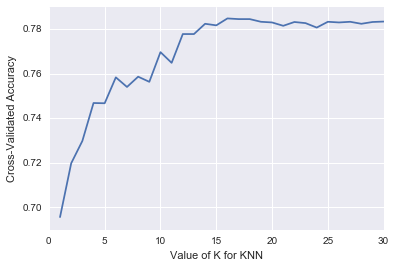

In [50]:
#plot results
plt.plot(k_range, grid_mean_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

In [51]:
# examine the best model
print grid.best_score_
print grid.best_params_
print grid.best_estimator_

0.7847
{'n_neighbors': 16}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=16, p=2,
           weights='uniform')


## Searching multiple parameters simultaneously

In [52]:
#define parameter values that should be searched
k_range = list(range(1, 31))
weight_options = ['uniform', 'distance']

In [53]:
# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(n_neighbors = k_range, weights=weight_options)
print param_grid

{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], 'weights': ['uniform', 'distance']}


In [54]:
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
grid.fit(X,y)

GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=16, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [55]:
grid.grid_scores_

[mean: 0.69570, std: 0.05098, params: {'n_neighbors': 1, 'weights': 'uniform'},
 mean: 0.69570, std: 0.05098, params: {'n_neighbors': 1, 'weights': 'distance'},
 mean: 0.71980, std: 0.04467, params: {'n_neighbors': 2, 'weights': 'uniform'},
 mean: 0.69290, std: 0.05127, params: {'n_neighbors': 2, 'weights': 'distance'},
 mean: 0.72980, std: 0.05782, params: {'n_neighbors': 3, 'weights': 'uniform'},
 mean: 0.72390, std: 0.05567, params: {'n_neighbors': 3, 'weights': 'distance'},
 mean: 0.74680, std: 0.05577, params: {'n_neighbors': 4, 'weights': 'uniform'},
 mean: 0.72790, std: 0.05570, params: {'n_neighbors': 4, 'weights': 'distance'},
 mean: 0.74670, std: 0.05920, params: {'n_neighbors': 5, 'weights': 'uniform'},
 mean: 0.74120, std: 0.05726, params: {'n_neighbors': 5, 'weights': 'distance'},
 mean: 0.75830, std: 0.05610, params: {'n_neighbors': 6, 'weights': 'uniform'},
 mean: 0.74280, std: 0.05823, params: {'n_neighbors': 6, 'weights': 'distance'},
 mean: 0.75400, std: 0.05949, para

In [56]:
#examine the best model
print grid.best_score_
print grid.best_params_

0.7847
{'n_neighbors': 16, 'weights': 'uniform'}


### Using the best parameters to make predictions

In [57]:
#train your model using best known parameters
knn = KNeighborsClassifier(n_neighbors=16, weights='uniform')
knn.fit(X, y)

knn.predict([3, 100, 30, 3, 68])

/Users/csiu87/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([1])

In [58]:
#shortcut: gridsearchCV refits the model automatically using all of the data
grid.predict([3, 100, 30, 3, 68])

/Users/csiu87/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([1])

# Lesson 9 - Evaluating Classification Model

 ### Can we predict whether the client will churn given their leads, spend, invoices, logins, and days_active

In [59]:
# define x and y
feature_cols = ['leads_30days','invoices_30days','spend_30days','logins_30days','days_live']

X = df[feature_cols]
y = df.churned

In [60]:
#split X and y into training and testing sets 

from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [61]:
# train a logistic regression model on the training set

from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [62]:
#make class predictions for the testing set
y_pred_class = logreg.predict(X_test)

### Classification accuracy: percentage of correct predictions

In [63]:
#calculate accuracy
from sklearn import metrics
print metrics.accuracy_score(y_test, y_pred_class)

0.7848


### Null accuracy: accuracy that could be achieved by always predicting the most frequent class

In [64]:
#examine the class distribution of the testing set (using a Pandas series method)
y_test.value_counts()

1    1266
0    1234
Name: churned, dtype: int64

In [65]:
#calculate the percentage of ones
y_test.mean()

0.5064

In [66]:
#calculate the percentage of zeros. This means that a dumb model that a client will not churn will be right 63% of the time.
#Compared to our 69% accuracy using logistic regression, our model performs only slightly better.
1- y_test.mean()

0.49360000000000004

In [67]:
#calculate null accuracy in one line; only works with binary and pandas series
max(y_test.mean(), 1 - y_test.mean())

0.5064

In [68]:
#calculate null accuracy for multi-class classification
y_test.value_counts().head(1)/len(y_test)

1    0.5064
Name: churned, dtype: float64

### Comparing the true and predicted response values

In [69]:
#print the first 25 true and predicted responses
print 'True:', y_test.values[0:25]
print 'Pred:', y_pred_class[0:25]

True: [0 1 1 0 1 0 0 1 1 1 0 1 1 0 0 0 0 1 1 0 1 0 1 0 0]
Pred: [1 1 1 0 1 1 0 1 1 1 0 1 1 0 0 0 0 1 1 0 1 0 1 0 0]


# Confusion Matrix

In [70]:
#first argument (col) is true values, second argument is predicted values
print metrics.confusion_matrix(y_test, y_pred_class)

[[ 891  343]
 [ 195 1071]]


In [71]:
#TN (predicted no churn, and did not churn) - 891
#FP (predicted churn, and churned; Type 1 error) - 343
#FN (predicted no churn, and did churn; Type II error) - 195
#TP (predicted churned, and chured)- 1071

#save confusion matrix and slice into four pieces
confusion = metrics.confusion_matrix(y_test, y_pred_class)

TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
TP = confusion[1, 1]

## Metrics computed from a confusion matrix

### Classification Accuracy: Overall, how often is the classifier correct?


In [72]:
print (TP + TN)/float(TP + TN + FP + FN)
print metrics.accuracy_score(y_test, y_pred_class)

0.7848
0.7848


### Classification Error: Overall, how often is the classifier incorrect (misclassification rate)?

In [73]:
print (FP + FN)/float(TP + TN + FP + FN)
print 1 - metrics.accuracy_score(y_test, y_pred_class)

0.2152
0.2152


### Sensitivity - When the actual value is positive, how sensitive is the classifier to detecting positive instances? Also know as "True Positive Rate" or "Recall"

In [74]:
print TP/float(FN + TP)
print metrics.recall_score(y_test, y_pred_class)

0.845971563981
0.845971563981


### Specificity - When the actual value is negative, how often is the prediction correct? How specific or selective is the classifier in predicting positive instances?

In [75]:
# our model is highly sensitive, but not highly specific
print TN/float(TN + FP)

0.722042139384


### False Positive Rate: When the actual value is negative, how often is the prediction incorrect?

In [76]:
print FP/float(TN + FP)

0.277957860616


### Precision:  When a positive value is predicted, how often is the prediction correct?

In [77]:
print TP/float(FP + TP)
print metrics.precision_score(y_test, y_pred_class)

0.757425742574
0.757425742574


Business objective - Priority is to identify clients that are most likely to churn. Therefore predicting a customer that was not going to churn, but churned (FN)  is less acceptable than predicting a customer was going to churn, but did not churn (FP). Therefore, I will optimize for precision or specificity. 

If my FP (predicted churned but did not churn) was more acceptable than FN (predicted not churned, but actually churned), then I would optimize for sensitivity. 

In this case my model is more highly specific, which is what I want versus highly sensitive. However, I am losing money by marketing to already surviving customers versus for a customer that I didn't catch and didn't identify did not waste any dollars.

## Adjusting the classification threshold

In [78]:
# print the first 10 predicted responses
logreg.predict(X_test)[0:10]

array([1, 1, 1, 0, 1, 1, 0, 1, 1, 1])

In [79]:
#pring the first 10 predicted probabilities of class membership. Each column represents each response class of 0 and 1. 
#In order to be predicted as class 1, the second col must exceed 0.5, which is why our 10 predicted responses are all 0. 
logreg.predict_proba(X_test)[:, :]

array([[ 0.20349206,  0.79650794],
       [ 0.21186859,  0.78813141],
       [ 0.20496695,  0.79503305],
       ..., 
       [ 0.35210666,  0.64789334],
       [ 0.90979594,  0.09020406],
       [ 0.13808231,  0.86191769]])

In [80]:
#print the first 10 predicted probabilities for class 1
logreg.predict_proba(X_test)[:, 1]

array([ 0.79650794,  0.78813141,  0.79503305, ...,  0.64789334,
        0.09020406,  0.86191769])

In [81]:
#store the predicted probabilities for class 1
y_pred_prob = logreg.predict_proba(X_test)[:, 1]

In [82]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

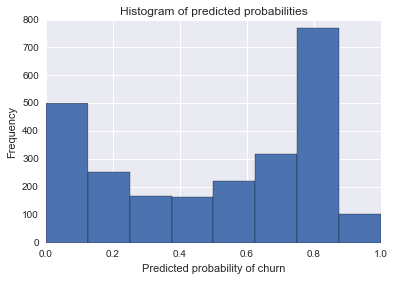

In [83]:
#histogram
plt.hist(y_pred_prob, bins=8)
plt.xlim(0,1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of churn')
plt.ylabel('Frequency')

About 780 of our observations fall between 0.8 and 0.9 probability of churn. 500 fall in < 0.1 probability of churn

### Decrease the threshold for predicting churn in order to increase the sensitivity of the classifier

In [84]:
# predict churn if the predicted probability is greater than 0.3
from sklearn.preprocessing import binarize 
y_pred_class = binarize([y_pred_prob], 0.3)[0]

In [85]:
# print first 10 predicted probabilities
y_pred_prob[0:10]

array([ 0.79650794,  0.78813141,  0.79503305,  0.29203663,  0.7428995 ,
        0.77655579,  0.05209046,  0.88814388,  0.82146363,  0.99999598])

In [86]:
# print first 10 classes with lower threshold
y_pred_class[0:10]

array([ 1.,  1.,  1.,  0.,  1.,  1.,  0.,  1.,  1.,  1.])

In [87]:
# print confusion matrix(default of 0.5)
print confusion

[[ 891  343]
 [ 195 1071]]


In [88]:
# print confusion matrix (default of 0.3)
print metrics.confusion_matrix(y_test, y_pred_class)

[[ 703  531]
 [ 117 1149]]


In [89]:
# sensitivity has increased (used to be .84)
print 1149 / float(117 + 1149)

0.907582938389


In [90]:
# specifity has decreased (used to be .72)
print 703 / float(703 + 531)

0.569692058347


# ROC Curves and Area Under the Curve (AUC)

### See how sensitivity and specificity are affected by various thresholds

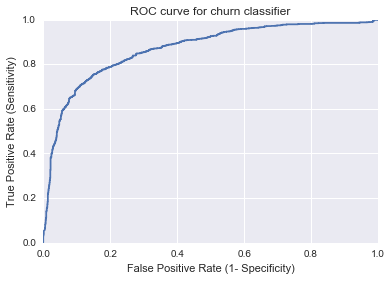

In [91]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for churn classifier')
plt.xlabel('False Positive Rate (1- Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [92]:
# define a function that accepts a threshold and prints sensitivity and specificity
def evaluate_threshold(threshold): 
    print 'Sensitivity:', tpr[thresholds > threshold][-1]
    print 'Specificity:', 1-fpr[thresholds > threshold][-1]

In [93]:
evaluate_threshold(0.5)

Sensitivity: 0.845181674566
Specificity: 0.722042139384


In [94]:
evaluate_threshold(0.3)

Sensitivity: 0.907582938389
Specificity: 0.572123176661


### AUC is the percentage of the ROC plot that is underneath the curve

In [95]:
print metrics.roc_auc_score(y_test, y_pred_prob)

0.869275542105


In [96]:
# calculate cross validated AUC
from sklearn.cross_validation import cross_val_score
cross_val_score(logreg, X, y, cv=10, scoring='roc_auc').mean()

0.87064027505195019

End of lesson 9

In [97]:
 #precision recall curve
#logistic regression coefficients